In [0]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2
!pip3 install torch
!pip3 install torchvision
!pip3 install tensorboardX
from IPython import display
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
import tensorflow as tf
from tensorflow import nn, layers
from tensorflow.contrib import layers as clayers 

import numpy as np

In [0]:
DATA_FOLDER = './tf_data/DCGAN/CIFAR'

## Load Data

In [0]:
def cifar_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5)),
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

In [5]:
dataset = cifar_data()
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_batches = len(dataloader)

Files already downloaded and verified


In [0]:
IMAGES_SHAPE = (64, 64, 3)
NOISE_SIZE = 100

## Models 

##### Ops

In [0]:
def default_conv2d(inputs, filters):
    return layers.conv2d(
        inputs,
        filters=filters,
        kernel_size=4,
        strides=(2, 2),
        padding='same',
        data_format='channels_last',
        use_bias=False,
    )

def default_conv2d_transpose(inputs, filters):
    return layers.conv2d_transpose(
        inputs,
        filters=filters,
        kernel_size=4,
        strides=(2, 2),
        padding='same',
        data_format='channels_last',
        use_bias=False,
    )

def noise(n_rows, n_cols):
    return np.random.normal(size=(n_rows, n_cols))

#### Discriminator

In [0]:
def discriminator(x):
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        with tf.variable_scope("conv1"):
            conv1 = default_conv2d(x, 128)
            conv1 = nn.leaky_relu(conv1,alpha=0.2)
        
        with tf.variable_scope("conv2"):
            conv2 = default_conv2d(conv1, 256)
            conv2 = layers.batch_normalization(conv2)
            conv2 = nn.leaky_relu(conv2,alpha=0.2)
            
        with tf.variable_scope("conv3"):
            conv3 = default_conv2d(conv2, 512)
            conv3 = layers.batch_normalization(conv3)
            conv3 = nn.leaky_relu(conv3,alpha=0.2)
            
        with tf.variable_scope("conv4"):
            conv4 = default_conv2d(conv3, 1024)
            conv4 = layers.batch_normalization(conv3)
            conv4 = nn.leaky_relu(conv3,alpha=0.2)
        
        with tf.variable_scope("linear"):
            linear = clayers.flatten(conv4)
            linear = clayers.fully_connected(linear, 1)
        
        with tf.variable_scope("out"):
            out = nn.sigmoid(linear)
    return out

#### Generator

In [0]:
def generator(z):
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
        
        with tf.variable_scope("linear"):
            linear = clayers.fully_connected(z, 1024 * 4 * 4)
            
        with tf.variable_scope("conv1_transp"):
            # Reshape as 4x4 images
            conv1 = tf.reshape(linear, (-1, 4, 4, 1024))
            conv1 = default_conv2d_transpose(conv1, 512)
            conv1 = layers.batch_normalization(conv1)
            conv1 = nn.relu(conv1)
        
        with tf.variable_scope("conv2_transp"):
            conv2 = default_conv2d_transpose(conv1, 256)
            conv2 = layers.batch_normalization(conv2)
            conv2 = nn.relu(conv2)
            
        with tf.variable_scope("conv3_transp"):
            conv3 = default_conv2d_transpose(conv2, 128)
            conv3 = layers.batch_normalization(conv3)
            conv3 = nn.relu(conv3)
            
        with tf.variable_scope("conv4_transp"):
            conv4 = default_conv2d_transpose(conv3, 3)
        
        with tf.variable_scope("out"):
            out = tf.tanh(conv4)
    return out

## Graph Optimization

#### Inputs

In [0]:
## Real Input
X = tf.placeholder(tf.float32, shape=(None, )+IMAGES_SHAPE)
## Latent Variables / Noise
Z = tf.placeholder(tf.float32, shape=(None, NOISE_SIZE))

#### Outputs

In [0]:
# Generator
G_sample = generator(Z)
# Discriminator
D_real = discriminator(X)
D_fake = discriminator(G_sample)

#### Losses

In [0]:
# Generator
G_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=D_fake, labels=tf.ones_like(D_fake)
    )
)

# Discriminator
D_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=D_real, labels=tf.ones_like(D_real)
    )
)

D_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=D_fake, labels=tf.zeros_like(D_fake)
    )
)

D_loss = D_loss_real + D_loss_fake

#### Optimizers

In [0]:
# Obtain trainable variables for both networks
train_vars = tf.trainable_variables()

G_vars = [var for var in train_vars if 'generator' in var.name]
D_vars = [var for var in train_vars if 'discriminator' in var.name]

num_epochs = 200

In [0]:
G_opt = tf.train.AdamOptimizer(2e-4).minimize(G_loss, var_list=G_vars,)
D_opt = tf.train.AdamOptimizer(2e-4).minimize(D_loss, var_list=D_vars,)

## Training

#### Testing

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples, NOISE_SIZE)

#### Inits

In [0]:
BATCH_SIZE = 100
NUM_EPOCHS = 200

# Start interactive session
session = tf.InteractiveSession()
# Init Variables
tf.global_variables_initializer().run()
# Init Logger
logger = Logger(model_name='DCGAN1', data_name='CIFAR10')

#### Train

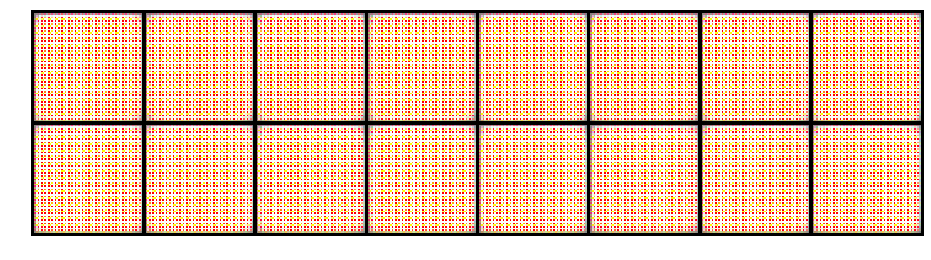

Epoch: [0/200], Batch Num: [100/500]
Discriminator Loss: 1.2873, Generator Loss: 0.4741
D(x): 1.0000, D(G(z)): 0.5000


KeyboardInterrupt: ignored

In [18]:
# Start interactive session
session = tf.InteractiveSession()
# Init Variables
tf.global_variables_initializer().run()
# Iterate through epochs
for epoch in range(NUM_EPOCHS):
    for n_batch, (batch,_) in enumerate(dataloader):
        
        # 1. Train Discriminator
        X_batch = batch.permute(0, 2, 3, 1).numpy()
        feed_dict = {X: X_batch, Z: noise(BATCH_SIZE, NOISE_SIZE)}
        _, d_error, d_pred_real, d_pred_fake = session.run(
            [D_opt, D_loss, D_real, D_fake], feed_dict=feed_dict
        )

        # 2. Train Generator
        feed_dict = {Z: noise(BATCH_SIZE, NOISE_SIZE)}
        _, g_error = session.run(
            [G_opt, G_loss], feed_dict=feed_dict
        )
        
        if n_batch % 100 == 0:
            display.clear_output(True)
            # Generate images from test noise
            test_images = session.run(
                G_sample, feed_dict={Z: test_noise}
            )
            # Log Images
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches, format='NHWC');
            # Log Status
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

In [0]:
!tensorboard --logdir="./runs"